# Required Libraries

In [77]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import shutil

import pywt
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sn
import joblib
import json

# Checking a Test Image

In [78]:
img = cv2.imread('test_images/sharapova1.jpg')

In [79]:
img.shape

(555, 700, 3)

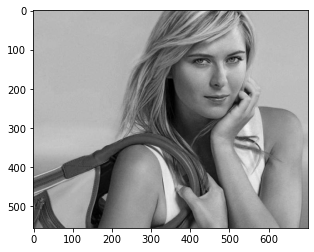

In [80]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img,'gray')

# Haar Cascades - Face & Eyes Detection

In [81]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade  = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_eye.xml')

# Cropped Image of Face & Eyes

In [82]:
def get_cropped_image(image_path):
    
    img = img = cv2.imread(image_path)
    
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Face Detection:
    
    faces = face_cascade.detectMultiScale(gray_img,1.3,5)

    # Eye Detection:

    for (x,y,w,h) in faces: 
        eyes = eye_cascade.detectMultiScale(gray_img[y:y+h,x:x+w])

        if len(eyes) >=2:
            cropped_img = img[y:y+h,x:x+w]
            return cropped_img
        else:
            return None

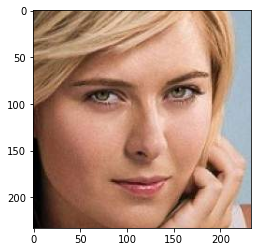

In [83]:
cropped_img = get_cropped_image('test_images/sharapova1.jpg')
plt.imshow(cropped_img)

# Cropped Images (ROI) Directory

In [19]:
data_path = "dataset"
dirs = []
for path in glob.glob(data_path+"/*"):
    dirs.append(path)

In [20]:
dirs=dirs[1:]
dirs

['dataset\\lionel_messi',
 'dataset\\maria_sharapova',
 'dataset\\roger_federer',
 'dataset\\serena_williams',
 'dataset\\virat_kohli']

In [25]:
data_path = "dataset"
cropped_data_path = "dataset/cropped_images"

if os.path.exists(cropped_data_path):
    shutil.rmtree(cropped_data_path)
else:
    os.mkdir(cropped_data_path)

In [ ]:
# Folder of Cropperd Images

for img_dir in dirs:
    celebrity = img_dir.split('\\')[-1]
    
    if not os.path.exists(cropped_data_path+'/'+celebrity):
        os.mkdir(cropped_data_path+'/'+celebrity)
    
    count = 1
    cropped_file_path = cropped_data_path+'/'+celebrity+'/'
    for entry in glob.glob(img_dir+'/*'):
        if get_cropped_image(entry) is not None:
            cv2.imwrite(cropped_file_path+celebrity+'_'+str(count)+'.png',
                       get_cropped_image(entry))
            count += 1

 After __Manual Editing__ of the cropped images, a Celebrity dictionary is made for generation of Data Sets.

In [84]:
celeb_dict = {}
for img_dir in dirs:
    
    file_list = []
    celebrity = img_dir.split('\\')[-1]
    
    for file in glob.glob(cropped_data_path+'/'+celebrity+'/*'):
        file_list.append(file)
    celeb_dict[celebrity] = file_list

In [85]:
celeb_dict

{'lionel_messi': ['dataset/cropped_images/lionel_messi\\lionel_messi1.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi10.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi11.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi13.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi14.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi15.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi16.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi17.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi18.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi19.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi2.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi20.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi22.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi23.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi24.png',
  'dataset/cropped_images/lionel_messi\\lionel_messi25.png',
  'dataset

# Feature Engineering

Using **Wavelet Decomposition** of the Image to extract the facial features.

In [86]:
def wavdecomp(img,wavelet='haar',mode='symmetric',level=1):
    
    imgArray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    imgArray = np.float32(imgArray)
    imgArray /= 255;
        
   # Decomposition

    coeffs           = pywt.wavedec2(imgArray,wavelet,mode,level)
    final_coeffs     = list(coeffs)
    final_coeffs[0] *= 0
    
    # Reconstruction
    final_imgarray   = pywt.waverec2(final_coeffs,wavelet,mode)
    final_imgarray  *= 255
    final_imgarray   = np.uint8(final_imgarray)
    
    return final_imgarray


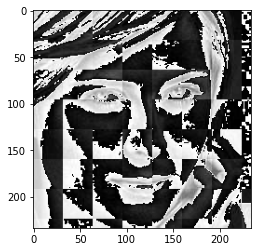

In [87]:
decomp_img = wavdecomp(cropped_img,level=5)
plt.imshow(decomp_img,cmap='gray')

# Data Set Preparation

In [88]:
class_dict = {}
count = 0
for celebrity in celeb_dict.keys():
    class_dict[celebrity] = count
    count += 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [32]:
X,y = [], []
for celebrity, file_path in celeb_dict.items():
    
    for img in file_path:
       
        im                = cv2.imread(img)
        scalled_raw_im    = cv2.resize(im,(32,32))
        im_decomp         = wavdecomp(im,'db1',level=5)
        scalled_im_decomp = cv2.resize(im_decomp,(32,32))
        
        combine_im        = np.vstack(
            (scalled_raw_im.reshape(32*32*3,1),
             scalled_im_decomp.reshape(32*32,1)))
        
        X.append(combine_im)
        y.append(class_dict[celebrity])

In [33]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [34]:
X.shape

(168, 4096)

In [35]:
y = np.array(y).reshape(len(y),1)

In [36]:
y.shape

(168, 1)

# Model Training

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [59]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

# Model
model = SVC()
model.fit(X_train,y_train.ravel())

# Score
model.score(X_test,y_test.ravel())

0.8095238095238095

In [60]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.88      0.88      0.88         8
           2       0.62      0.83      0.71         6
           3       0.83      0.71      0.77         7
           4       0.75      0.90      0.82        10

    accuracy                           0.81        42
   macro avg       0.82      0.81      0.80        42
weighted avg       0.84      0.81      0.81        42



# Hyperparameter Tuning

In [61]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'C': [1,10,100,1000],
            'kernel': ['rbf','linear','poly','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,50,100,150,200]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [0.1,0.3,1,3,5,10]
        }
    }
}

In [62]:
scores = []
best_estimator = {}

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

for algo,mp in model_params.items():
    
    estimator = mp['model']
    clf = GridSearchCV(estimator,mp['params'],cv=5,return_train_score=False)
    clf.fit(X_train,y_train.ravel())
    scores.append({
        'model':algo,
        'best_score': clf.best_score_ ,
        'best_params': clf.best_params_    
    })
    best_estimator[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    
    

In [63]:
df

,model,best_score,best_params
0,svm,0.889231,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.833846,{'n_estimators': 200}
2,logistic_regression,0.897231,{'C': 0.1}


In [64]:
best_estimator

{'svm': SVC(C=1, gamma='auto', kernel='linear', probability=True),
 'random_forest': RandomForestClassifier(n_estimators=200),
 'logistic_regression': LogisticRegression(C=0.1, solver='liblinear')}

# Score Predictions & Confusion Matrix

In [65]:
for algo in model_params.keys():
    print("With best estimator of "+algo+" : "
          +str(np.round(best_estimator[algo].score(X_test,y_test),2))+'\n')

With best estimator of svm : 0.86

With best estimator of random_forest : 0.86

With best estimator of logistic_regression : 0.83



In [89]:
best_classifier = best_estimator['svm']

In [67]:
cm = confusion_matrix(y_test,best_classifier.predict(X_test))
cm

array([[9, 0, 0, 1, 1],
       [0, 7, 1, 0, 0],
       [0, 0, 5, 1, 0],
       [0, 1, 0, 6, 0],
       [0, 0, 1, 0, 9]], dtype=int64)

Text(69.0, 0.5, 'True Classses')

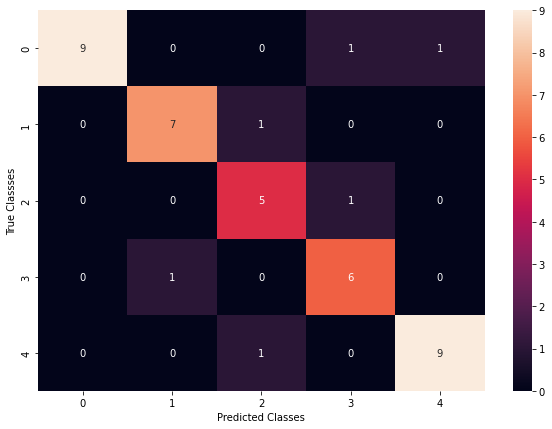

In [68]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classses')

In [69]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

# Saving the Model

In [70]:
joblib.dump(best_classifier,'Project_Classification.pkl')

['Project_Classification.pkl']

In [71]:
# Saving the Class dictionary as json

with open("Class_dictionary","w") as f:
    f.write(json.dumps(class_dict))